# LLM Working Tutorial

### This tutorial demonstrates how to work with climate/oceanographic datasets using a catalog-driven approach. Instead of hard-coding file paths, the notebook uses a central JSON catalog (datasets.json) to manage dataset metadata and dynamically dispatch loaders from dataset.py.


## Set up and imports

In [51]:
# --- 1) Setup & Imports ---
import os, json, importlib, textwrap
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

# Render nicely in notebooks
%matplotlib inline
plt.rcParams["figure.dpi"] = 120

## Load the dataset catalog
Read datasets.json (data catalog) into memory so we can browse datasets and their metadata.

In [52]:
# --- 2) Load the Dataset Catalog (datasets.json) ---
CATALOG_PATH = "datasets.json"  # adjust if you keep it elsewhere

assert os.path.exists(CATALOG_PATH), f"Catalog file not found: {CATALOG_PATH}"

with open(CATALOG_PATH, "r", encoding="utf-8") as f:
    catalog_data = json.load(f)

# Expect a top-level key "datasets" with a list of entries
catalog_list = catalog_data.get("datasets", [])
assert isinstance(catalog_list, list) and len(catalog_list) > 0, "No datasets found in catalog."

# Normalize to dict keyed by dataset name
CATALOG = {d["name"]: d for d in catalog_list}

print("Datasets available:")
for name in CATALOG.keys():
    print(" •", name)


Datasets available:
 • Indian Ocean grid
 • GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1)
 • ERA5 Atmospheric Surface Analysis


## Helper Fucntions

### Define describe_dataset() to pretty-print catalog entries.

### Shows:

- Name & description

- Temporal bounds

- Spatial bounds

- Variables (with descriptions & units in a table)

In [56]:
# --- 3) Explore Dataset Metadata (Description, Bounds, Variables) ---

def describe_dataset(ds_meta: dict):
    """Pretty print a single catalog entry."""
    print(f"# {ds_meta.get('name','<unnamed>')}\n")
    print(ds_meta.get("description","(no description)"))
    print()

    tb = ds_meta.get("temporal_bounds", {})
    sb = ds_meta.get("spatial_bounds", {})

    print("Time range:", tb.get("start_time"), "→", tb.get("end_time"))
    print("Spatial bounds:",
          f"lat[{sb.get('min_lat')},{sb.get('max_lat')}],",
          f"lon[{sb.get('min_lon')},{sb.get('max_lon')}]")
    print()

    # Variables table
    variables = (ds_meta.get("variables") or {}).get("variables", [])
    if variables:
        print("Variables:")
        df_vars = pd.DataFrame(variables)
        display(df_vars)
    else:
        print("(no variables listed)")

# Choose one for inspection (hardcode here; swap as needed)
INSPECT_NAME = "Indian Ocean grid"
describe_dataset(CATALOG[INSPECT_NAME])


# Indian Ocean grid

Our Indian Ocean IO.zarr is a 1972-2022 blended dataset for the Arabian Sea and Bay of Bengal formated as a .zarr file, containing daily cleaned and interpolated data from variables across multiple sources, mostly from processed NASA/NOAA and Copernicus collections and the ERA5 reanalysis products.

Time range: 1979-01-01 → 2022-12-31
Spatial bounds: lat[-12.0,32.0], lon[42.0,102.0]

Variables:


,standard_name,description,units
0,adt,Sea surface height above geoid (SL_TAC),m
1,air_temp,Air temperature at 2 meters above the surface ...,K
2,mlotst,Mean ocean mixed layer thickness (GLORY),m
3,sla,Sea level anomaly (SL_TAC),m
4,so,Sea salinity concentration (GLORY),PSU
5,sst,Sea surface temperature (ERA5),K
6,topo,Topography (SRTM30+),m
7,u_curr,U-component of total surface currents (OSCAR),m/s
8,v_curr,V-component of total surface currents (OSCAR),m/s
9,ug_curr,U-component of geostrophic surface currents (O...,m/s


## Loader registry (bridges catalog → dataset.py)

- Imports your loader module (dataset.py).

- Defines load_from_catalog(ds_name):

- Reads access_function from catalog.

- Dynamically calls the right loader (e.g., load_climate_data).

- Passes platform, path, and extra args.

- Raises clear errors if something is misconfigured

In [57]:
# --- 4) Dataset Loader Registry (link datasets.json → dataset.py) ---

# Import your loader functions module
loaders = importlib.import_module("dataset")  # this is dataset.py in the same folder

def load_from_catalog(ds_name: str, **kwargs):
    """
    Dispatch to the correct loader based on the catalog's access.access_function.
    Skips datasets that don't specify an access_function (e.g., ERA5 we are not using now).
    """
    meta = CATALOG[ds_name]
    access = meta.get("access", {})
    fn_name = access.get("access_function", "").strip()

    if not fn_name:
        raise ValueError(
            f"Dataset '{ds_name}' has no 'access_function' in catalog; "
            "skipping (ERA5/Arraylake not used)."
        )

    if not hasattr(loaders, fn_name):
        raise AttributeError(
            f"Loader function '{fn_name}' not found in dataset.py for dataset '{ds_name}'."
        )

    fn = getattr(loaders, fn_name)

    # Standard arguments taken from catalog
    platform = access.get("platform")
    path = access.get("path")
    other_args = access.get("other_args", {}) or {}

    # Allow overrides via **kwargs when calling
    return fn(path=path, platform=platform, meta=meta, **other_args, **kwargs)


## Pick a dataset and preview it.

- Select dataset by name (PREVIEW_NAME).

- Load it via load_from_catalog.

- Summarize object type and structure with quick_summary().

- Peek at variables with peek().

Helper functions:

*describe_dataset()* → Explore dataset metadata.

*load_from_catalog()* → Load data into xarray/pandas automatically.

*quick_summary()* → Quick object summary.

*peek()* → Inspect specific variables/dimensions.

In [58]:
# --- 5) Select & Preview a Dataset (quick peek) ---

PREVIEW_NAME = INSPECT_NAME  # reuse the one we inspected above; change if needed

obj = load_from_catalog(PREVIEW_NAME)

def quick_summary(obj):
    """Print a tiny summary whether it's xarray or pandas."""
    if isinstance(obj, xr.Dataset):
        print(obj)  # Dataset summary
    elif isinstance(obj, xr.DataArray):
        print(obj)
    elif isinstance(obj, pd.DataFrame):
        print(obj.info())
        display(obj.head())
    else:
        print(type(obj))
        print(repr(obj)[:500])

quick_summary(obj)

def peek(obj, var: str | None = None, time_sel=None):
    """
    Minimal peek:
    - xarray.Dataset: print dims/coords; if var given, show one slice (isel 0 along non-time dims)
    - pandas.DataFrame: head()
    """
    if isinstance(obj, xr.Dataset):
        if var is not None and var in obj:
            da = obj[var]
        else:
            # pick first data variable if not provided
            first = next(iter(obj.data_vars)) if len(obj.data_vars) else None
            da = obj[first] if first else None

        if da is None:
            print("(No variables to peek)")
            return

        if time_sel is not None and "time" in da.dims:
            da = da.sel(time=time_sel)
        else:
            # show first index along dims > 1
            sel = {d: 0 for d, sz in da.sizes.items() if sz > 1}
            da = da.isel(**sel) if sel else da

        display(da)
    elif isinstance(obj, pd.DataFrame):
        display(obj.head())
    else:
        print("(peek) unsupported type:", type(obj))

# Example peek 1: Sea Surface Temperature ('sst')
peek(obj, var="sst")

# Example peek 2: Sea Level Anamoly ('sla')
#peek(obj, var="sla")


<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (

<xarray.DataArray 'sst' ()> Size: 4B
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 4B 32.0
    lon      float32 4B 42.0
    time     datetime64[ns] 8B 1979-01-01
Attributes:
    long_name:       Sea surface temperature
    nameCDM:         Sea_surface_temperature_surface
    nameECMWF:       Sea surface temperature
    product_type:    analysis
    shortNameECMWF:  sst
    standard_name:   sea_surface_temperature
    units:           K

## What the LLM is allowed to assume:

- obj is an xarray.Dataset already loaded earlier via load_from_catalog(...).

- Variables like sst, sla, etc. are present in obj (check with obj.data_vars).

## The LLM code should:

- Use xarray operations (.sel, .mean, .groupby('time.month'), etc.).

- Create one figure, one axes, and call plt.tight_layout().

- Keep everything inside the single code block (no external files).

## LLM → plotting code (how this pipeline works)

### This section lets a user write a plain-English request (e.g., “plot monthly mean SST over the Arabian Sea for 2015”) and have the notebook:

#### 1) prompt an LLM to generate runnable Python/matplotlib code that uses the already-loaded dataset object obj, and then

#### 2) safely execute that code in a sandboxed environment to render exactly one figure.

In [59]:
# --- 6A) Utilities: metadata, var picking, code extraction ---

import re, io, textwrap, contextlib
import numpy as np

CODE_FENCE = re.compile(r"```python(.*?)```", re.DOTALL)

def catalog_meta_for(ds_name: str):
    """Return the catalog entry dict."""
    return CATALOG[ds_name]

def list_vars_from_meta(meta: dict):
    vs = (meta.get("variables") or {}).get("variables", [])
    return [v.get("standard_name") for v in vs if v.get("standard_name")]

def pick_default_var(ds, meta: dict):
    """Choose a sensible default variable from the dataset + meta."""
    # Prefer a var that exists in ds; fall back to first ds var
    candidates = list_vars_from_meta(meta)
    for v in candidates:
        if isinstance(ds, xr.Dataset) and v in ds:
            return v
    if isinstance(ds, xr.Dataset) and len(ds.data_vars):
        return list(ds.data_vars)[0]
    return None


### System prompt template — make_system_prompt()

- Frames the LLM’s task: write code that only reads from in-memory variables (not disk/network), and builds one matplotlib figure.

- Constrains style (must call plt.tight_layout(); keep code self-contained) and names (obj is the xarray Dataset you should use).

- Encourages simple, transparent plotting (no hidden side effects, no extra figures).

In [60]:
# --- 6B) System prompt template ---

def make_system_prompt(meta: dict, default_var: str | None):
    """
    Build the system prompt that instructs the LLM to:
      - use ONLY xarray/pandas + matplotlib
      - operate on the already-loaded in-memory object `ds`
      - emit exactly ONE fenced Python code block
      - produce exactly ONE figure and call plt.tight_layout()
    Includes a couple of tiny few-shot examples to stabilize behavior.
    """
    # Pull useful bits from catalog metadata
    ds_name = meta.get("name", "<dataset>")
    var_list = list_vars_from_meta(meta)
    start = meta.get("temporal_bounds", {}).get("start_time", "unknown")
    end   = meta.get("temporal_bounds", {}).get("end_time", "unknown")
    sb    = meta.get("spatial_bounds", {}) or {}
    lat0, lat1 = sb.get("min_lat", "unk"), sb.get("max_lat", "unk")
    lon0, lon1 = sb.get("min_lon", "unk"), sb.get("max_lon", "unk")

    # Choose a variable for examples
    example_var = default_var or (var_list[0] if var_list else "var")

    # Few-shot examples: note the closing triple quotes at the end
    few_shots = f"""Example 1 (global mean time series):
```python
import matplotlib.pyplot as plt
da = ds['{example_var}']
ts = da.mean(dim=[d for d in da.dims if d != 'time'])
ts.plot()
plt.title('{example_var} global mean over time')
plt.tight_layout()

import matplotlib.pyplot as plt
da = ds['{example_var}']
if 'time' in da.dims:
    da = da.sel(time=str(da['time'].values[0]), method='nearest')
da.plot()
plt.title('{example_var} snapshot')
plt.tight_layout()
```"""

    prompt = f"""You are a precise plotting assistant for climate/ocean data.

CONTEXT
- The dataset "{ds_name}" is already loaded in memory as `ds` (xarray.Dataset or pandas.DataFrame).
- Variables available (from catalog): {var_list}.
- Time range: {start} to {end}.  Lat: [{lat0},{lat1}]  Lon: [{lon0},{lon1}].

HARD RULES
- Output EXACTLY ONE fenced Python code block.
- Use ONLY: xarray or pandas and matplotlib.pyplot as plt. (numpy is allowed if needed)
- NEVER read or write files. NEVER import network or OS libs. Operate ONLY on the in-memory `ds`.
- Produce exactly ONE figure and call plt.tight_layout().
- Keep code short, deterministic, and self-contained.

TIPS
- Prefer xarray ops when `ds` is an xarray.Dataset: .sel/.isel, .mean(), .groupby('time'), etc.
- If selecting a time that may not exist exactly, use label-based selection with method='nearest'.
- For time series: average over all non-time dims.
- For maps: choose a single time slice if 'time' is present.

{few_shots}"""

    return prompt

In [61]:
# --- Sanity test for make_system_prompt ---

# pick whichever dataset you loaded in Cell 5
meta = catalog_meta_for(PREVIEW_NAME)   # PREVIEW_NAME already defined in Cell 5
default_var = pick_default_var(obj, meta)  # obj = dataset loaded in Cell 5

prompt_text = make_system_prompt(meta, default_var)
print(prompt_text[:1200])   # print the first ~1200 chars so notebook isn't overwhelmed


You are a precise plotting assistant for climate/ocean data.

CONTEXT
- The dataset "Indian Ocean grid" is already loaded in memory as `ds` (xarray.Dataset or pandas.DataFrame).
- Variables available (from catalog): ['adt', 'air_temp', 'mlotst', 'sla', 'so', 'sst', 'topo', 'u_curr', 'v_curr', 'ug_curr', 'vg_curr', 'u_wind', 'v_wind', 'curr_speed', 'curr_dir', 'wind_speed', 'wind_dir', 'CHL_cmes-level3', 'CHL_cmes_flags-level3', 'CHL_cmes_uncertainty-level3', 'CHL_cmes-gapfree', 'CHL_cmes_flags-gapfree', 'CHL_cmes_uncertainty-gapfree', 'CHL_cci', 'CHL_cci_uncertainty', 'CHL_dinoef', 'CHL_dinoef_uncertainty', 'CHL_dinoef_flag'].
- Time range: 1979-01-01 to 2022-12-31.  Lat: [-12.0,32.0]  Lon: [42.0,102.0].

HARD RULES
- Output EXACTLY ONE fenced Python code block.
- Use ONLY: xarray or pandas and matplotlib.pyplot as plt. (numpy is allowed if needed)
- NEVER read or write files. NEVER import network or OS libs. Operate ONLY on the in-memory `ds`.
- Produce exactly ONE figure and call plt

### LLM call — Hugging Face Inference Router (OpenAI-compatible)

- Uses an OpenAI-compatible client pointed at HF Inference endpoints.

- Reads HF_TOKEN from your environment for auth.

- Sends the system prompt + user prompt (your natural-language plotting request) and retrieves code text only.

In [62]:
# --- 6C) LLM call via Hugging Face Inference Router (OpenAI-compatible) ---

import os
import textwrap
import openai

# If you have a .env, load it once near the top of the notebook (Cell 0):
# from dotenv import load_dotenv; load_dotenv()

HF_BASE_URL = os.getenv("OPENAI_BASE_URL") or "https://router.huggingface.co/v1"  # default to HF router
def _get_hf_client():
    """
    Create an OpenAI-compatible client that talks to the HF router.
    Requires HF_TOKEN in env (from your .env).
    """
    hf_token = os.getenv("HF_TOKEN")
    if not hf_token:
        raise RuntimeError(
            "HF_TOKEN not set. Add it to your .env and call load_dotenv(), or set:\n"
            "%env HF_TOKEN=hf_...   (avoid hardcoding secrets)"
        )
    return openai.Client(api_key=hf_token, base_url=HF_BASE_URL)

def nl_to_code(
    user_query: str,
    ds,                       # in-memory dataset (xarray.Dataset or pandas.DataFrame) from Cell 5
    meta: dict,               # catalog entry for PREVIEW_NAME
    model: str = "openai/gpt-oss-20b:fireworks-ai",  # choose a HF router-supported model ID
    temperature: float = 0.1
):
    """
    Turn a natural-language plotting request into a single fenced Python code block.
    Returns (code_str, full_llm_message_text).

    Dependencies defined earlier:
      - CODE_FENCE (regex from 6A)
      - pick_default_var (from 6A)
      - make_system_prompt (from 6B)
    """
    client = _get_hf_client()  # build AFTER env is loaded

    default_var = pick_default_var(ds, meta)
    system = make_system_prompt(meta, default_var)

    resp = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[
            {"role": "system", "content": system},
            {"role": "user",   "content": user_query},
        ],
    )

    content = resp.choices[0].message.content
    m = CODE_FENCE.search(content or "")
    if not m:
        raise ValueError(
            "No fenced python code block found in LLM response.\n\n"
            "--- Assistant said ---\n" + str(content)
        )

    code = textwrap.dedent(m.group(1)).strip()
    return code, content


### Safe executor — run_user_code_safely()

- Executes the returned code in a restricted namespace:

- Allowlist imports: numpy, pandas, xarray, matplotlib.pyplot and a few basics.

- Autocloses prior figures** and enforces one-figure policy (warns/fails if more than one).

- Blocks dangerous ops with regex checks (e.g., file I/O, network, subprocess, system calls).

- No writes to disk, no internet, no opening files—plots must be derived from obj or variables defined in-cell.

- Captures logs/exceptions so you can see what was executed and why failures happened.

In [63]:
# --- 6D) Safe executor (allowlisted imports) ---

import io, re, textwrap, contextlib
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Block obvious risky ops; still allow *safe* imports via our guard below.
FORBIDDEN_PATTERNS = [
    r"\bimport\s+(os|sys|subprocess|pathlib|shutil|requests|urllib|http|socket)\b",
    r"\bopen\(", r"\bto_csv\(", r"\bto_json\(", r"\bsavefig\(",
    r"\bexec\(", r"\beval\(",
]

# Modules the generated code is allowed to import
ALLOWED_MODULES = {
    "matplotlib", "matplotlib.pyplot",
    "numpy", "pandas", "xarray",
}

def _guarded_import(name, globals=None, locals=None, fromlist=(), level=0):
    """
    A safe __import__ that only permits allowlisted modules.
    Handles 'import matplotlib.pyplot as plt' and 'from xarray import ...'.
    """
    fullname = name
    # Quick check: allow if the requested module or any parent is allowed
    def allowed(mod):
        return (
            mod in ALLOWED_MODULES
            or any(mod.startswith(p + ".") for p in ALLOWED_MODULES)
        )
    if not allowed(fullname):
        raise ImportError(f"Import of '{fullname}' is blocked by sandbox.")
    return __import__(name, globals, locals, fromlist, level)

def run_user_code_safely(code: str, context: dict):
    # 1) Static checks
    for pat in FORBIDDEN_PATTERNS:
        if re.search(pat, code):
            raise RuntimeError(f"Blocked code pattern: {pat}")

    # 2) Create a minimal global namespace with allowed builtins and libs
    safe_builtins = {
        "len": len, "min": min, "max": max, "sum": sum, "range": range, "print": print,
        "slice": slice,
        "__import__": _guarded_import,  # enable guarded imports
    }
    safe_globals = {
        "__builtins__": safe_builtins,
        "np": np, "pd": pd, "xr": xr, "plt": plt,
    }
    safe_globals.update(context)  # e.g., {"ds": ds}

    # 3) Execute and capture stdout
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        exec(textwrap.dedent(code), safe_globals, {})
    return buf.getvalue()



### End-to-end demo (natural language → code → run)

- Example query string (e.g., “Plot the global mean sst as a time series for 2015. Unit: K”).

- Calls the LLM, prints the generated code, executes it safely, and displays the single figure.

---- LLM returned code ----

import matplotlib.pyplot as plt

sst = ds['sst']
sst_2015 = sst.sel(time=slice('2015-01-01', '2015-12-31'))
global_mean = sst_2015.mean(dim=[d for d in sst_2015.dims if d != 'time'])
global_mean.plot()
plt.title('Global mean SST (2015)')
plt.ylabel('Temperature (K)')
plt.tight_layout()

---- Execution logs ----

(none)


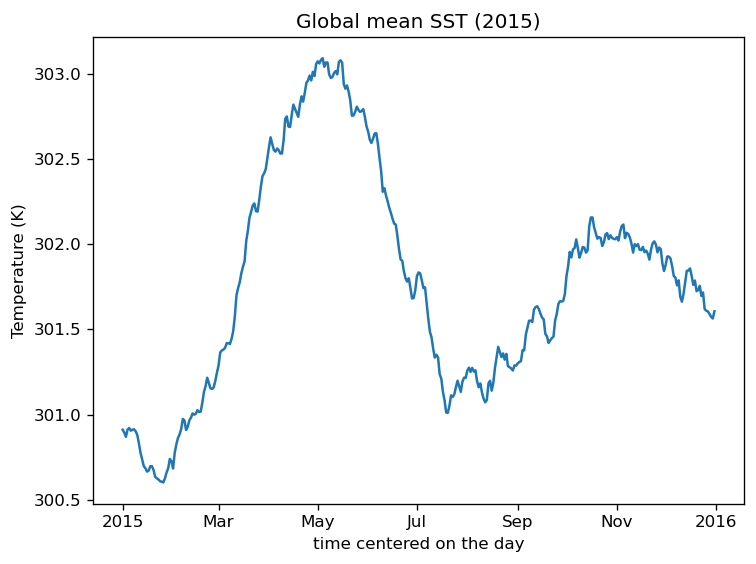

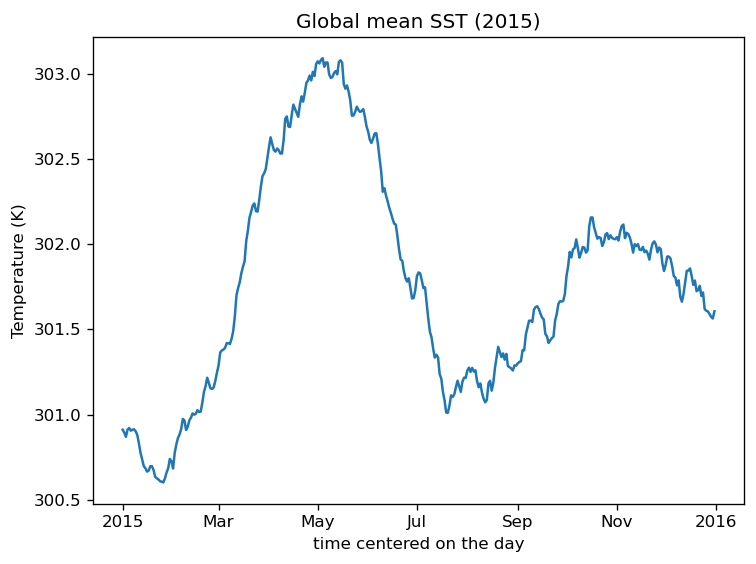

In [66]:
# --- 6E) Demo query: natural language -> code -> run -> show ---

active_name = PREVIEW_NAME          # e.g., the IO dataset you loadedd
meta = catalog_meta_for(active_name)
ds_loaded = obj                     # from Cell 5

query = "Plot the global mean sst as a time series for 2015. Unit: K"
code, raw_msg = nl_to_code(query, ds_loaded, meta)

# Run safely
plt.close("all")
logs = run_user_code_safely(code, {"ds": ds_loaded})

# Show results
print("---- LLM returned code ----\n")
print(code)
print("\n---- Execution logs ----\n")
print(logs or "(none)")
display(plt.gcf())  # last figure


## Plot helpers (fallbacks)

If the LLM struggles, you can call small utilities that:

- Build a time series by averaging over lat/lon, then plotting by time.

- Render a snapshot map for a selected date/variable.

These helpers live just after the demo and are handy references for the LLM’s intended plotting style.

In [65]:
# Example helpers
# 1) makes a time series by averaging the variable across all non-time dimensions
def plot_timeseries_mean(ds, var, time_slice=None): # ds: xarray.Dataset var: variable name 
    da = ds[var]
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))
    ts = da.mean(dim=[d for d in da.dims if d!="time"]) # ts: 1-D over time
    ts.plot()
    plt.title(f"{var} global mean over time")
    plt.tight_layout()

# 2) plots a single time slice as a 2-D map
def plot_snapshot_map(ds, var, time=None):
    da = ds[var]
    if time is not None:
        da = da.sel(time=time) # da: 2-D; if the exact timestamp isn’t present, may use .sel(time=time, method="nearest")
    da.plot()
    plt.title(f"{var} snapshot")
    plt.tight_layout()
